## "Revolutionizing Agriculture: Apple Disease Detection Using Deep Learning CNN Model"

**In the agricultural sector, the early detection and management of plant diseases are vital for ensuring crop health and maximizing yield. Traditional methods of disease detection often rely on manual inspection, which can be time-consuming and prone to human error. To address these challenges, our project focuses on leveraging the power of deep learning, specifically convolutional neural networks (CNNs), to automate the detection of diseases in apple trees.**

 **Understanding the Problem** : *Apple trees are susceptible to various diseases, such as apple scab, powdery mildew, and cedar apple rust, which can significantly impact fruit quality and yield if not identified and managed promptly. Manual detection of these diseases is challenging due to the subtle visual cues present on affected leaves, making it difficult for farmers to detect diseases early and accurately.



 **Proposed Solution** : *Our project proposes a solution that involves collecting a dataset of images of healthy and diseased apple leaves. These images will be used to train a CNN, a type of deep learning model that is well-suited for image classification tasks. The CNN will learn to differentiate between healthy and diseased leaves based on the visual features present in the images.

# *Import all the Dependencies*

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential, models
import pathlib

#  *Set all the Constants*

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20

# *Import data into tensorflow dataset object*

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "apple.leaves",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size =BATCH_SIZE
)

Found 6011 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___healthy']

In [5]:
len(dataset)

188

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 2 0 1 0 1 1 1 1 1 2 1 2 2 0 0 0 0 0 0 2 0 2 0 0 1 1 1 0 1 2]


In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


# *Visualize some of the images from our dataset*

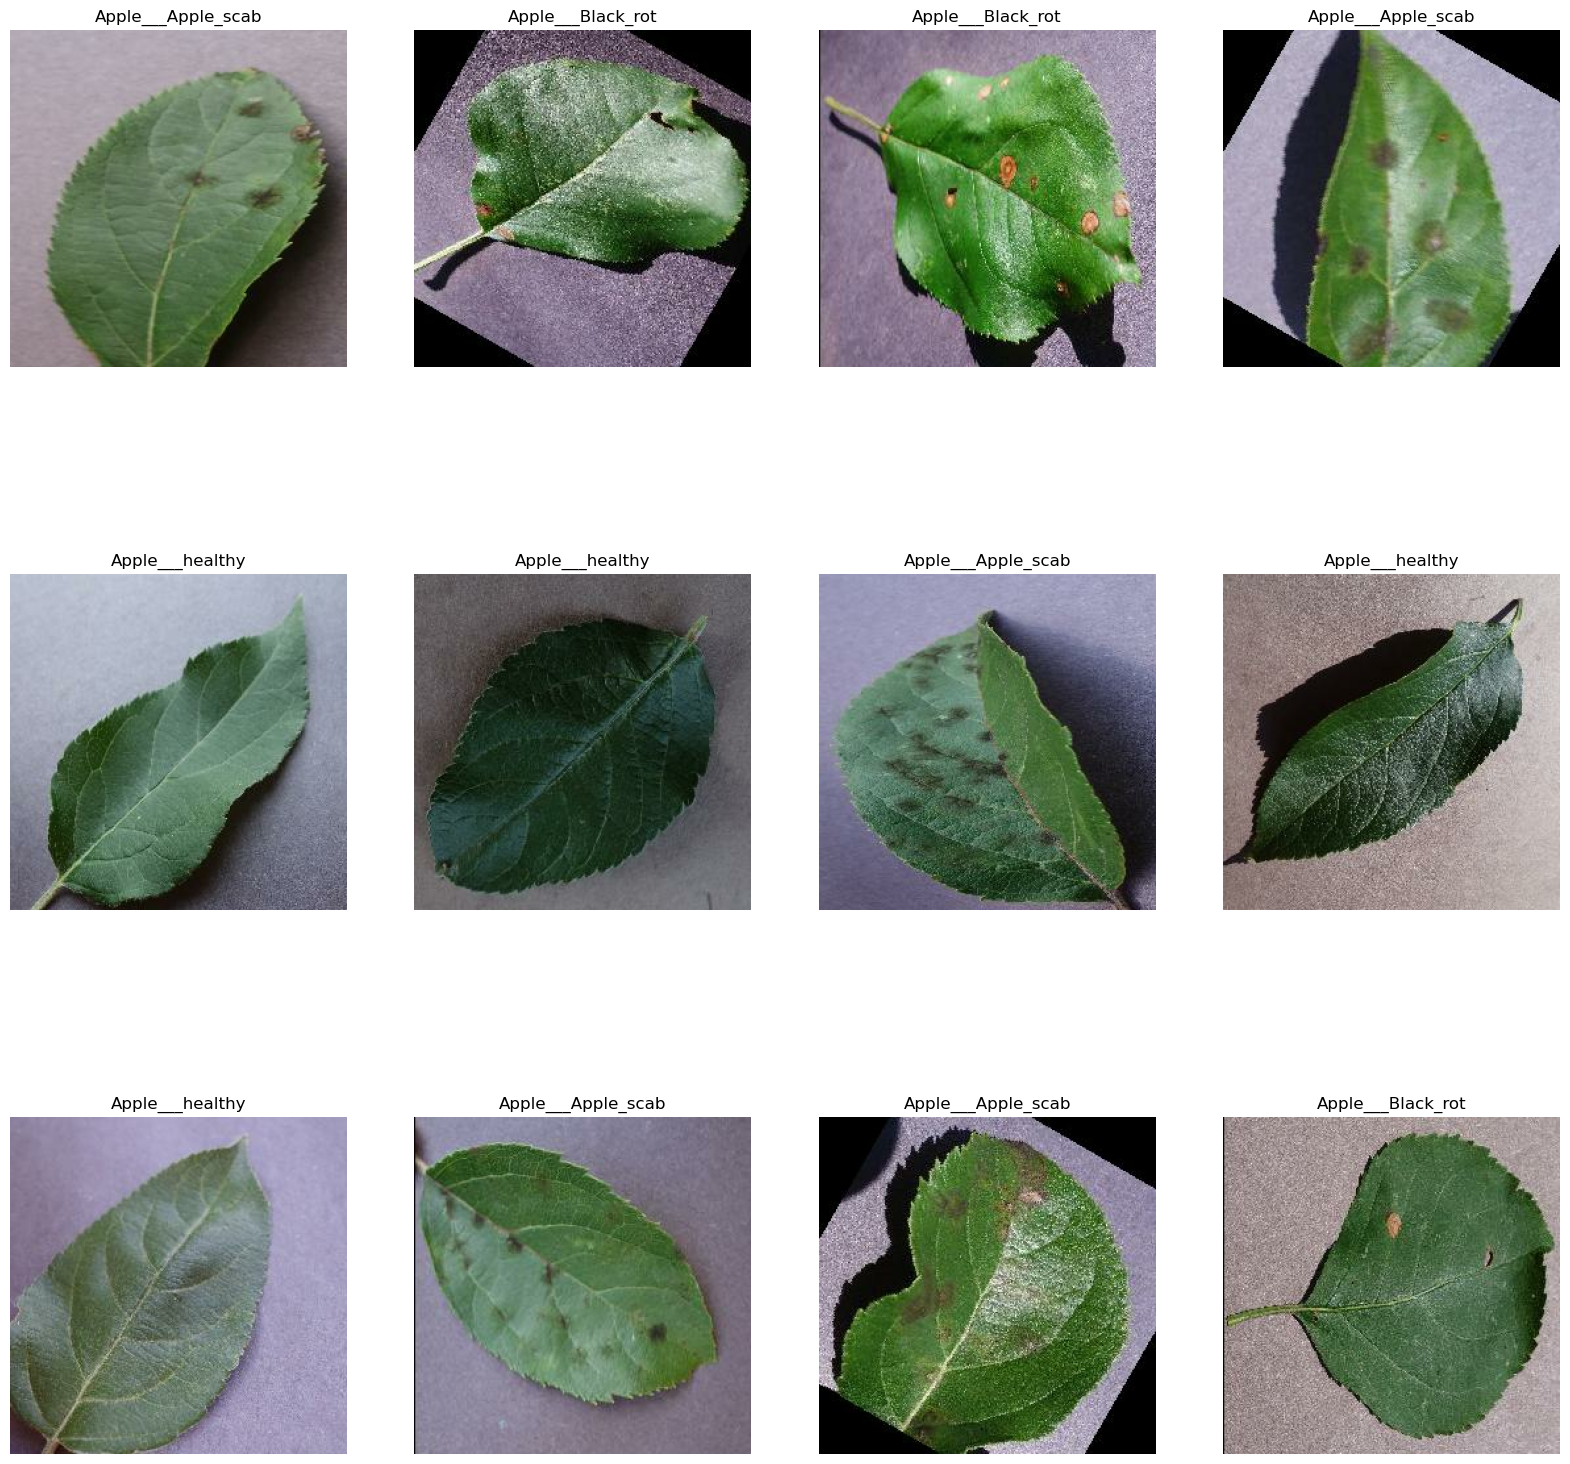

In [8]:
plt.figure(figsize=(20,20))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

# *datasplit into train_test_validation*

In [9]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [10]:
train_size = 0.8
len(dataset)*train_size

150.4

In [11]:
train_ds = dataset.take(194)
len(train_ds)

188

In [12]:
test_ds=dataset.skip(194)
len(test_ds)

0

In [13]:
val_size = 0.1
len(dataset)*val_size

18.8

In [14]:
val_ds = test_ds.take(24)
len(val_ds)

0

In [15]:
test_ds = test_ds.skip(24)
len(test_ds)

0

In [16]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,shuffle=True,shuffle_size = 10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

150

In [19]:
len(val_ds)

18

In [20]:
len(test_ds)

20

##  *Cache, Shuffle, and Prefetch the Dataset*

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# *Building the Model*

### Creating a Layer for Resizing and Normalization
Before we feed our images to network, we should be resizing it to the desired size. Moreover, to improve model performance, we should normalize the image pixel value (keeping them in range 0 and 1 by dividing by 256). This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

You might be thinking why do we need to resize (256,256) image to again (256,256). You are right we don't need to but this will be useful when we are done with the training and start using the model for predictions. At that time somone can supply an image that is not (256,256) and this layer will resize it

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

## *Data Augmentation*
Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.

In [23]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

###  *Applying Data Augmentation to Train Dataset*

In [24]:
train_ds = train_ds.map(
    lambda x, y:(data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## *Model Architecture*

In [25]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,(3,3), activation='relu' , input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape= input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## *Compiling the Model*

In [27]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)     

In [28]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20


150/150 [==============================] - 81s 516ms/step - loss: 0.8551 - accuracy: 0.5842 - val_loss: 0.9963 - val_accuracy: 0.6795
Epoch 2/20
150/150 [==============================] - 87s 579ms/step - loss: 0.4809 - accuracy: 0.8025 - val_loss: 0.5209 - val_accuracy: 0.8581
Epoch 3/20
150/150 [==============================] - 87s 579ms/step - loss: 0.2788 - accuracy: 0.8901 - val_loss: 0.3165 - val_accuracy: 0.9124
Epoch 4/20
150/150 [==============================] - 83s 549ms/step - loss: 0.1770 - accuracy: 0.9285 - val_loss: 0.6885 - val_accuracy: 0.8494
Epoch 5/20
150/150 [==============================] - 85s 564ms/step - loss: 0.1238 - accuracy: 0.9533 - val_loss: 0.3072 - val_accuracy: 0.9229
Epoch 6/20
150/150 [==============================] - 80s 534ms/step - loss: 0.0816 - accuracy: 0.9679 - val_loss: 0.1825 - val_accuracy: 0.9545
Epoch 7/20
150/150 [==============================] - 76s 508ms/step - loss: 0.1055 - accuracy: 0.9614 - val_loss: 0.4556 - val_

In [29]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 5s 129ms/step - loss: 0.0742 - accuracy: 0.9734


In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 150}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
history.history['accuracy']

[0.5841501355171204,
 0.8025026321411133,
 0.8900938630104065,
 0.9284671545028687,
 0.9532846808433533,
 0.9678832292556763,
 0.9614181518554688,
 0.9607924818992615,
 0.9843587279319763,
 0.9747653603553772,
 0.9847757816314697,
 0.9879040718078613,
 0.9906152486801147,
 0.9851928949356079,
 0.9939520359039307,
 0.9920750856399536,
 0.9893639087677002,
 0.9937434792518616,
 0.9893639087677002,
 0.9937434792518616]

## *Plotting the Accuracy and Loss Curves*

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

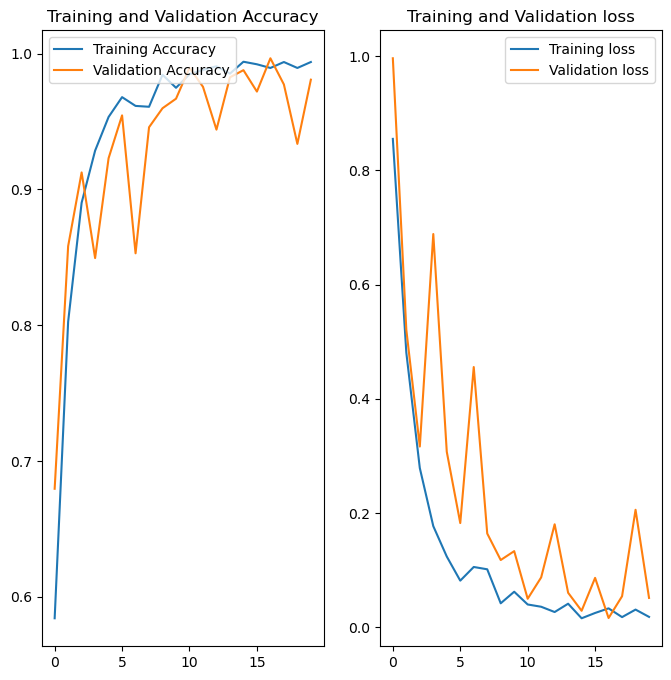

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS) , acc, label='Training Accuracy')
plt.plot(range(EPOCHS) , val_acc, label='Validation Accuracy')
plt.legend(loc= 'upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(1 ,2 ,2)
plt.plot(range(EPOCHS) , loss, label='Training loss')
plt.plot(range(EPOCHS) , val_loss, label='Validation loss')
plt.legend(loc= 'upper right')
plt.title('Training and Validation loss')
plt.show()

## *Run prediction on a sample image*

first image to predict
actual label : Apple___healthy
1/1 [==============================] - 0s 264ms/step
predicted label: Apple___healthy


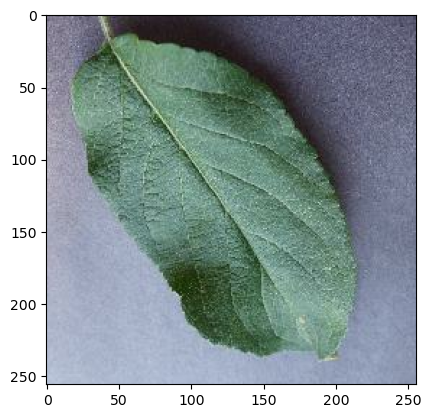

In [41]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label :",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

## *Write a function for inference*

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])),2)
    return predicted_class, confidence

## *Now run inference on few sample images*

1/1 [==============================] - 0s 55ms/step


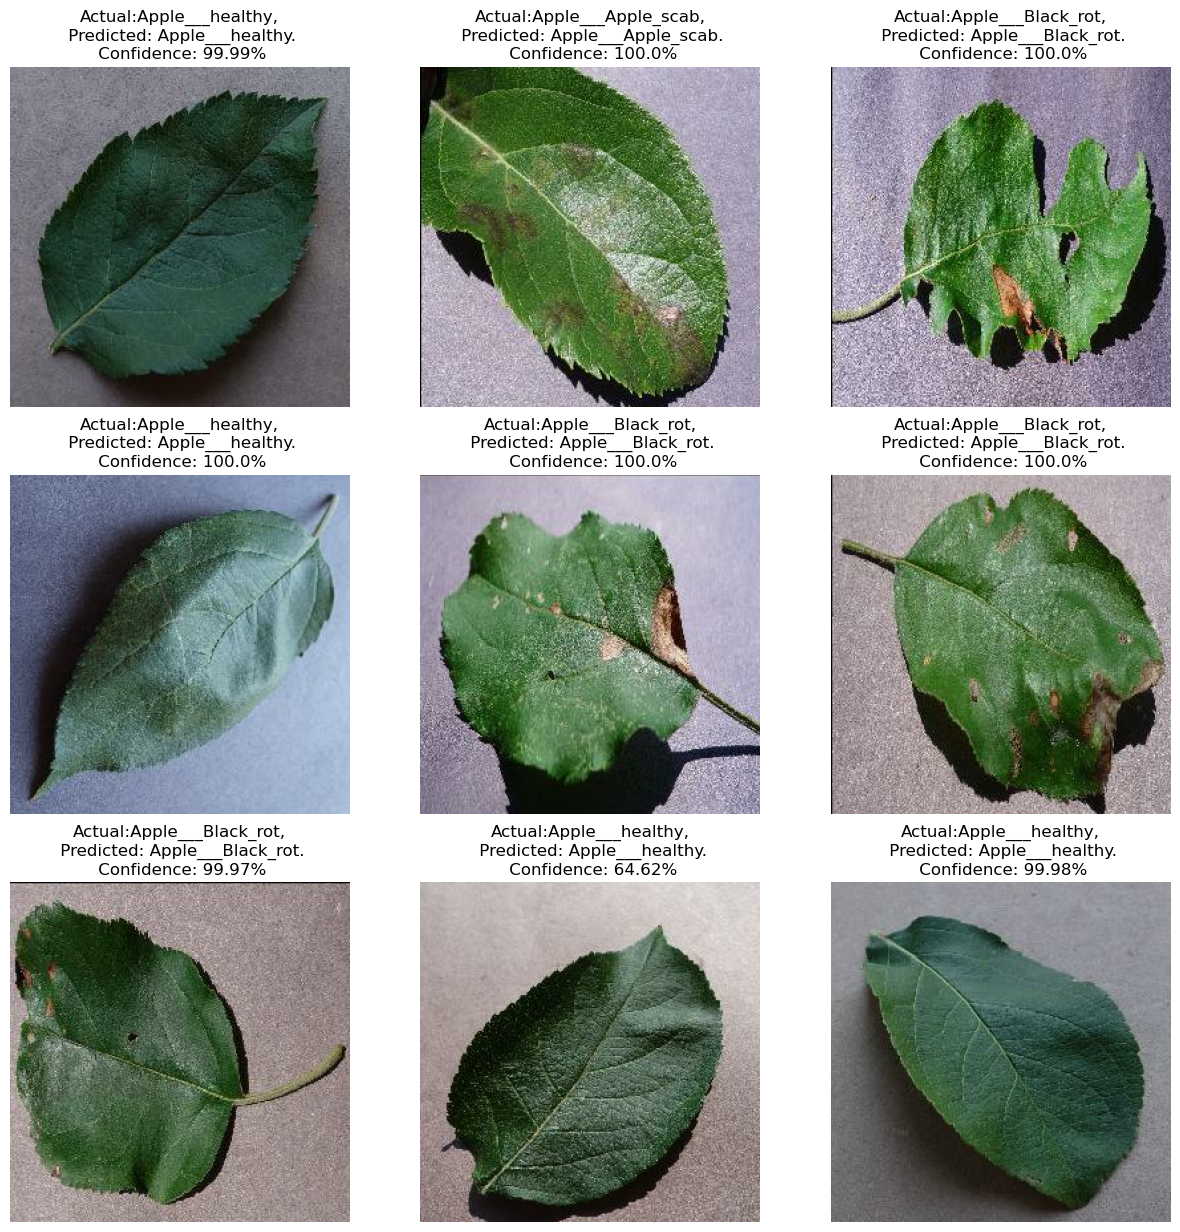

In [43]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")
        